# 3 - Mapas

Vamos também gerar alguns mapas como parte de nossa análise de dados. Afinal, temos 96 gráficos, e precisamos extrair as principais informações dos dados. Os mapas que faremos serão:

- Atendimento (matrícula) absoluto por tempo.
- Atendimento (matrícula) relativo (relação à população) por tempo.
- Fila (demanda) absoluto por tempo.
- Fila (demanda) relativo por tempo.
- Variação entre junho de 2016 e dezembro de 2017 do atendimento absoluto.
- Variação entre junho de 2016 e dezembro de 2017 do atendimento relativo.

Primeiro, pegaremos os dados e faremos a função que gera os gráficos.

In [31]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import imageio
from pylab import rcParams
from matplotlib.pyplot import figure

distritos = gpd.read_file('dados/LAYER_DISTRITO/DEINFO_DISTRITO.shp')

def geraMapa(periodo, tema, atributo, colormap='inferno'):
    dados = dados_educ_pop[dados_educ_pop['MES_ANO_REF'] == periodo]
    dados = dados[['DISTRITO', atributo]]

    for i in distritos.index:
        nome = distritos.at[i, 'NOME_DIST'].split(' ')
        if 'JD' in nome:
            nome[0] = 'JARDIM'
        if 'CID' in nome:
            nome[0] = 'CIDADE'
        distritos.at[i, 'NOME_DIST'] = ' '.join(nome)
        recorte = dados[dados['DISTRITO'] == distritos.at[i, 'NOME_DIST']]
        distritos.at[i, atributo] = recorte[atributo].values[0]
            
    plt.ioff()
    ax = distritos.plot(column=atributo, cmap=colormap, legend=True)
    ax.set_title(tema + " em " + periodo)
    ax.axis('off')
    plt.savefig('mapas/' + atributo + '_' + periodo + '.png', bbox_inches='tight')
    plt.close()
    
def geraGif(periodos, atributo):
    with imageio.get_writer('gifs/' + atributo + '.gif', mode='I', duration=0.25) as writer:
        for periodo in periodos:
            image = imageio.imread('mapas/' + atributo + '_' + periodo + '.png')
            writer.append_data(image)

## Mapas do atendimento absoluto por tempo

Para esses mapas, será gerado um imagem para cada período de referência (trimestre). Depois disso, será gerado um gif para ver melhor a evolução.

In [32]:
dados_educ_pop = pd.read_csv('dados/dados_educ_pop.csv', sep = ',')
periodos = dados_educ_pop.MES_ANO_REF.unique()

for periodo in periodos:
    geraMapa(periodo=periodo, tema='Atendimento absoluto das creches', atributo='MAT_CRECHE', colormap='viridis')
    
geraGif(periodos, 'MAT_CRECHE')

/home/lsflp/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


## Mapa do atendimento relativo por tempo

Para esses mapas, será gerado um imagem para cada período de referência (trimestre). Depois disso, será gerado um gif para ver melhor a evolução.

In [36]:
dados_educ_pop['ATEND_REL'] = dados_educ_pop['MAT_CRECHE'] / dados_educ_pop['TOTAL']

for periodo in periodos:
    geraMapa(periodo=periodo, tema='Atendimento relativo à população', atributo='ATEND_REL', colormap="viridis")
    
geraGif(periodos, 'ATEND_REL')

/home/lsflp/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

## Mapa da fila absoluta por tempo

Para esses mapas, será gerado um imagem para cada período de referência (trimestre). Depois disso, será gerado um gif para ver melhor a evolução.

In [40]:
for periodo in periodos:
    geraMapa(periodo=periodo, tema='Demanda por vagas de creches', atributo='DEM_CRECHE')
    
geraGif(periodos, 'DEM_CRECHE')

/home/lsflp/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

## Mapa da fila relativa por tempo

Para esses mapas, será gerado um imagem para cada período de referência (trimestre). Depois disso, será gerado um gif para ver melhor a evolução.

In [41]:
dados_educ_pop['FILA_REL'] = dados_educ_pop['DEM_CRECHE'] / dados_educ_pop['TOTAL']

for periodo in periodos:
    geraMapa(periodo=periodo, tema='Demanda por vagas de creches', atributo='FILA_REL')
    
geraGif(periodos, 'FILA_REL')

/home/lsflp/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

<Figure size 3600x4800 with 0 Axes>

## Mapa da evolução do número de matrículas

Esses mapas trarão a variação, do número de matrículas, de junho de 2006 a dezembro de 2017. O primeiro apresenta as vagas absolutas e o segundo, as relativas à população.

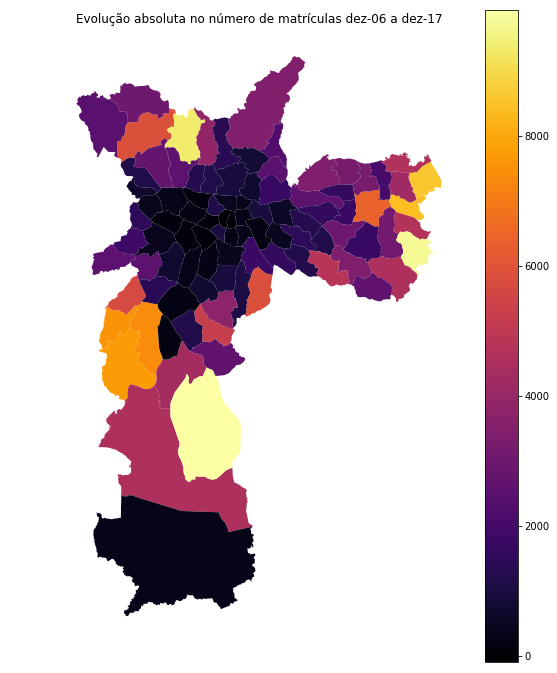

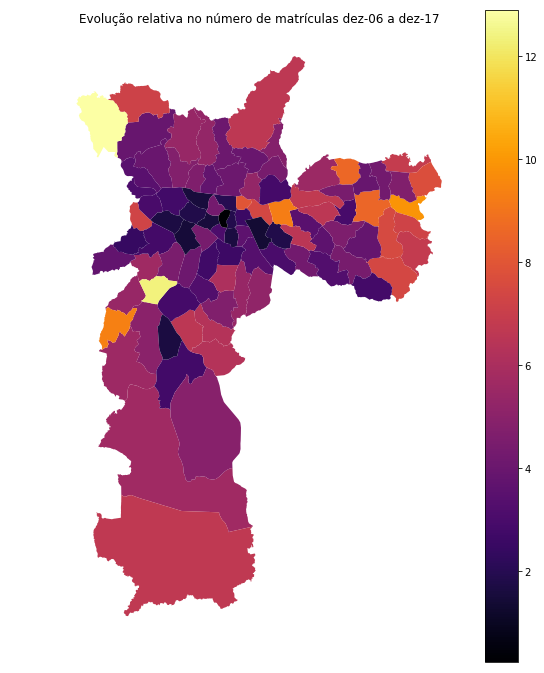

In [43]:
def geraMapaEvolucao(data, atributo, tema, colormap="inferno"):
    dados = data[['DISTRITO', atributo]]

    for i in distritos.index:
        recorte = dados[dados['DISTRITO'] == distritos.at[i, 'NOME_DIST']]
        distritos.at[i, atributo] = recorte[atributo].values

    ax = distritos.plot(column=atributo, cmap=colormap, legend=True)
    ax.set_title(tema)
    ax.axis('off')

dados_matricula = dados_educ_pop[['DISTRITO', 'MAT_CRECHE', 'MES_ANO_REF']]
dados_jun_2006 = dados_matricula[dados_matricula['MES_ANO_REF'] == 'jun-06']
dados_jun_2006.columns = ['DISTRITO', 'MAT_JUN_06', 'MES_ANO_REF']
dados_dez_2017 = dados_matricula[dados_matricula['MES_ANO_REF'] == 'dez-17']
dados_dez_2017.columns = ['DISTRITO', 'MAT_DEZ_17', 'MES_ANO_REF']

dados_matricula = dados_jun_2006.merge(dados_dez_2017, on = ['DISTRITO'])
dados_matricula = dados_matricula[['DISTRITO', 'MAT_JUN_06', 'MAT_DEZ_17']]

dados_matricula['EV_ABS_NUM'] = dados_matricula['MAT_DEZ_17'] - dados_matricula['MAT_JUN_06']
dados_matricula['EV_ABS_PC'] = dados_matricula['MAT_DEZ_17'] / dados_matricula['MAT_JUN_06']
geraMapaEvolucao(dados_matricula, 'EV_ABS_NUM', tema="Evolução absoluta no número de matrículas dez-06 a dez-17")
geraMapaEvolucao(dados_matricula, 'EV_ABS_PC', tema="Evolução relativa no número de matrículas dez-06 a dez-17")

## Mapa da evolução da demanda

Esses mapas trará a variação, em número de crianças, de junho de 2006 a dezembro de 2017. O primeiro apresenta a demanda absoluta e o segundo, a relativa à população.

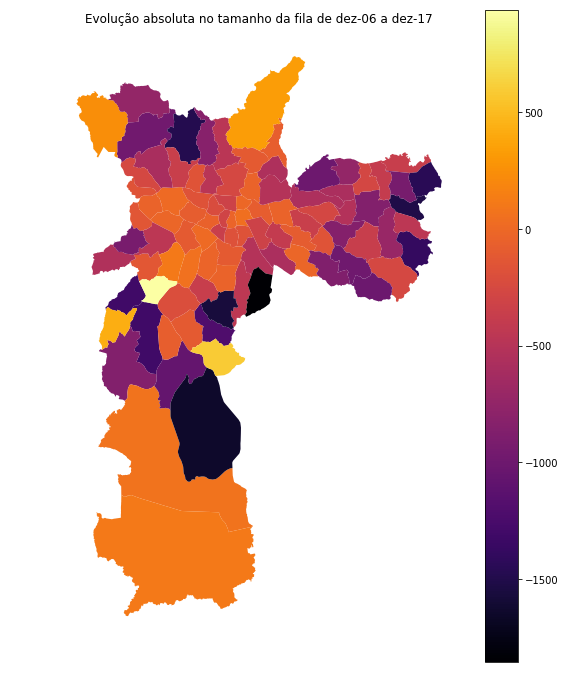

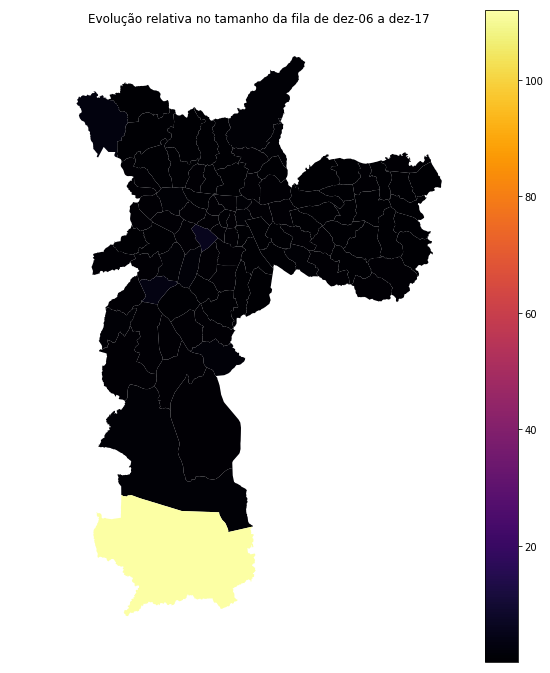

In [44]:
dados_demanda = dados_educ_pop[['DISTRITO', 'DEM_CRECHE', 'MES_ANO_REF']]
dados_jun_2006 = dados_demanda[dados_demanda['MES_ANO_REF'] == 'jun-06']
dados_jun_2006.columns = ['DISTRITO', 'DEM_JUN_06', 'MES_ANO_REF']
dados_dez_2017 = dados_demanda[dados_demanda['MES_ANO_REF'] == 'dez-17']
dados_dez_2017.columns = ['DISTRITO', 'DEM_DEZ_17', 'MES_ANO_REF']

dados_demanda = dados_jun_2006.merge(dados_dez_2017, on = ['DISTRITO'])
dados_demanda = dados_demanda[['DISTRITO', 'DEM_JUN_06', 'DEM_DEZ_17']]

dados_demanda['EV_ABS_NUM'] = dados_demanda['DEM_DEZ_17'] - dados_demanda['DEM_JUN_06']
dados_demanda['EV_ABS_PC'] = dados_demanda['DEM_DEZ_17'] / dados_demanda['DEM_JUN_06']
geraMapaEvolucao(dados_demanda, 'EV_ABS_NUM', tema="Evolução absoluta no tamanho da fila de dez-06 a dez-17")
geraMapaEvolucao(dados_demanda, 'EV_ABS_PC', tema="Evolução relativa no tamanho da fila de dez-06 a dez-17")